<a href="https://colab.research.google.com/github/lasupernova/Tensorflow_apps/blob/master/SciAbstractClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An NLP model that makes reading scientific abstract easier by separating an abstract into 5 parts.

 - Background
 - Objectives
 - Methods
 - Results
 - Conclusion

The model aims to replicate and modify (improved) the models built in the following paper:
https://arxiv.org/abs/1710.06071

In [1]:
#check access to GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-46674db3-6d55-acab-3481-f7063e3d91e6)


The PubMed 200k RCT dataset (https://github.com/Franck-Dernoncourt/pubmed-rct)  will be used for training the model, based on the following paper:

https://arxiv.org/abs/1710.06071

In [2]:
#download data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [49]:
#download helper function to use throughout script
!wget https://raw.githubusercontent.com/lasupernova/Tensorflow_apps/master/helpers.py

--2021-10-12 22:18:44--  https://raw.githubusercontent.com/lasupernova/Tensorflow_apps/master/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10252 (10K) [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-12 22:18:44 (57.9 MB/s) - ‘helpers.py’ saved [10252/10252]



In [78]:
#imports
import os
import statistics
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import tensorflow_hub as hub
from helpers import calculate_results
import tensorflow as tf

## Model using 10% of data set

In [5]:
#check pubmed_20k_rct dataset files
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


NOTE: <br>
train.txt - train dataset<br>
test.txt - test dataset<br>
dev.txt - validation dataset<br>

In [6]:
DATA_DIR = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [7]:
#get list of filenames in dir
f_names = [f"{DATA_DIR}{os.sep}{f_name}" for f_name in os.listdir(DATA_DIR)]
f_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

### Pre-process data

In [8]:
#read data into variables
def import_data_from_txt(f_name):
  """
  Read data contained in specified file and save data (text) to variable to.

  PARAMS:
    f_name(str) - path to file

  RETURNS:
    data(lst) - list with text data save as entries
  """
  extension = f_name.split(".")[-1]
  if extension != "txt":
    print("ERROR! Extension of type .txt required!")
  with open(f_name, "r") as f:
    return f.readlines()

In [9]:
# for file in f_names:
#   name = file.split("/")[-1].split(".")[0]
#   name = 

In [10]:
train_data = import_data_from_txt('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
test_data = import_data_from_txt('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')
val_data = import_data_from_txt('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')

In [11]:
train_data[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [12]:
#create list of dicts to store data in 
def preprocess_data(f_name):
    """
    Get information from text file specified.
    Read data contained in data list into list of dicts, with every data list entry being represented by a dict.

    PARAMS:
      f_name(str) - path to file

    RETURNS:
      lstOdct(lst) - list of dicts
    """
    data = import_data_from_txt(f_name)
    line_counter = 0
    lstOdct = []
    for entry in data:
      if entry.startswith("###"):
        line_counter = 1
        new_abstract = []
      elif entry == "\n":
        line_counter = 0
        #get line count for current abstract
        total_lines = len(new_abstract)
        #append line count for current abstract to each dict in sublist
        new_abstract = [dict(item, **{'total_lines':total_lines}) for item in new_abstract]
        #add current abstract entries to lstOdct
        lstOdct.extend(new_abstract)
      else:
        label, sentence = entry.strip().split("\t")
        curr_dict = {
            "line_num" : line_counter,
            "label" : label.lower(),
            "text" : sentence.lower()
        }
        new_abstract.append(curr_dict)
        line_counter  += 1
    return lstOdct

In [13]:
%%time
train_dct = preprocess_data('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
test_dct = preprocess_data('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')
val_dct = preprocess_data('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')

CPU times: user 524 ms, sys: 109 ms, total: 634 ms
Wall time: 639 ms


In [14]:
train_dct[:5]

[{'label': 'objective',
  'line_num': 1,
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 12},
 {'label': 'methods',
  'line_num': 2,
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 12},
 {'label': 'methods',
  'line_num': 3,
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 12},
 {'label': 'methods',
  'line_num': 4,
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 12},
 {'label': 'methods',
  'line_num': 5,
  'text': 'secondary outcome measures included the western ontari

In [15]:
#convert list of dicts into DataFrame in order to visualize
train_df = pd.DataFrame(train_dct)
test_df = pd.DataFrame(test_dct)
val_df = pd.DataFrame(val_dct)
train_df.head(20)

,line_num,label,text,total_lines
0,1,objective,to investigate the efficacy of @ weeks of dail...,12
1,2,methods,a total of @ patients with primary knee oa wer...,12
2,3,methods,outcome measures included pain reduction and i...,12
3,4,methods,pain was assessed using the visual analog pain...,12
4,5,methods,secondary outcome measures included the wester...,12
5,6,methods,"serum levels of interleukin @ ( il-@ ) , il-@ ...",12
6,7,results,there was a clinically relevant reduction in t...,12
7,8,results,the mean difference between treatment arms ( @...,12
8,9,results,"further , there was a clinically relevant redu...",12
9,10,results,these differences remained significant at @ we...,12


In [16]:
# check what the distribution of abstract length is
len_distrib_sorted = train_df.total_lines.value_counts().sort_values(ascending=False).to_frame()

In [17]:
# check what the distribution of abstract length is
len_distrib = train_df.total_lines.value_counts().to_frame().sort_index()

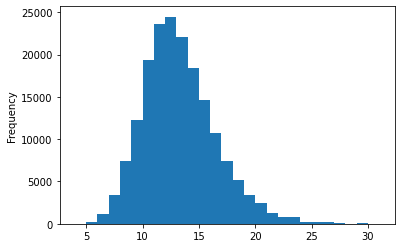

In [18]:
train_df.total_lines.plot.hist(bins=len(len_distrib))
plt.show()

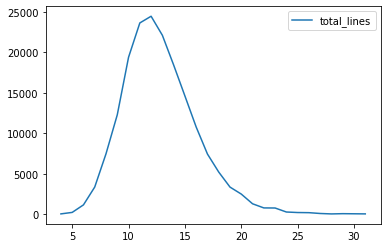

In [19]:
len_distrib.plot()
plt.show()

In [20]:
# check what the distribution of abstract labels is
label_distrib = train_df.label.value_counts()

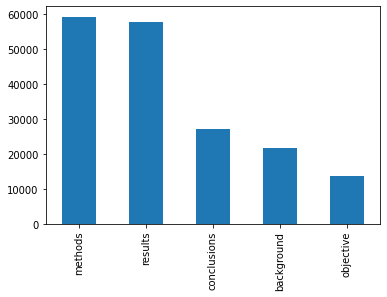

In [21]:
label_distrib.plot(kind="bar")
plt.show() 


### Encode data

 - save text (x) and labels (y) to separate lists to pass on to ML model later on
 -convet labels to numeric form using OneHotEncoding

In [22]:
X_train = train_df["text"].to_list()
X_test = test_df["text"].to_list()
X_val = val_df["text"].to_list()
len(X_train), len(X_test), len(X_val)

(180040, 30135, 30212)

In [23]:
y_train = train_df["label"].to_list()
y_test = test_df["label"].to_list()
y_val = val_df["label"].to_list()
len(y_train), len(y_test), len(y_val)

(180040, 30135, 30212)

In [24]:
X_train[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [25]:
y_train[:5]

['objective', 'methods', 'methods', 'methods', 'methods']

In [26]:
#get indeces -  convert to array to be ableto use with sklearn OneHotEncoder
labels = np.array(y_train)

In [27]:
labels

array(['objective', 'methods', 'methods', ..., 'results', 'conclusions',
       'conclusions'], dtype='<U11')

##### One-hot Encoding

In [28]:
#one hot encode labels - non-sparse matrix in order to be compatible with tf.constant()
enc = OneHotEncoder(sparse=False)

In [29]:
encoded_train_labels = enc.fit_transform(labels.reshape(-1, 1)) #fit to training labels AND trasnform those labels

In [30]:
encoded_train_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [31]:
tf.constant(encoded_train_labels)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [32]:
#use fit_transformed encoder to also trasnform validation and test labels
encoded_test_labels = enc.transform(np.array(y_test).reshape(-1,1)) #encoder was already fitted (to training labels) - transform test and val labels now
encoded_val_labels = enc.transform(np.array(y_val).reshape(-1,1)) 

##### Label Encoding

In [33]:
label_enc = LabelEncoder()
lab_encoded_train_labels = label_enc.fit_transform(labels.reshape(-1, 1))
lab_encoded_test_labels = label_enc.transform(np.array(y_test).reshape(-1,1)) #encoder was already fitted (to training labels) - transform test and val labels now
lab_encoded_val_labels = label_enc.transform(np.array(y_val).reshape(-1,1)) 

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
lab_encoded_train_labels[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

##### Get class names from encoder

--> this could be done with any of the two encoders, but here the information in extracted from OneHotEncoder instance (enc)

In [35]:
#get class names and numbers from label encoder
num_classes = len(label_enc.classes_)
classes = list(label_enc.classes_)
classes

['background', 'conclusions', 'methods', 'objective', 'results']

In [36]:
# ##for labels from onehotencoder: use
# enc.categories_

In [37]:
dir(enc.categories_)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

## Train Models

Different models will be tried, including:<br>
 - sklearn's NaiveBayes (tf-idf) encoder <br>
 - TensorFlow Hub Pretrained Feature Extractor<br>
 - Conv1D with character embeddings<br>
 - Pretrained token embeddings (same as 2nd model from above) + charater embeddings (same as 3rd from above)<br>
 - Pretrained token embeddings (same as 2nd model from above) + charater embeddings (same as 3rd from above) + positional embeddings



### Naive Bayes (tf-idf)

In [38]:
# create model (here: using Pipeline)

baseline_model = Pipeline(
    [
     ("tf-idf", TfidfVectorizer()),
     ("clf", MultinomialNB())
    ]
)


In [39]:
#compile model not needed for sklearn models

In [40]:
#fit model
baseline_model.fit(X=X_train,
                   y=lab_encoded_train_labels #using Label Encoded labels
                   )

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [41]:
#evaluate baseline model -->NOTE: similar to '.evaluate' in keras
baseline_model.score(X=X_val,
                        y=lab_encoded_val_labels)

0.7218323844829869

In [42]:
#make and save predictions using baseline model
baseline_preds = baseline_model.predict(X_val)

In [43]:
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [51]:
baseline_metrics = calculate_results(lab_encoded_val_labels, baseline_preds)

### 1D CNN with Token Embeddings

In [52]:
#info regarding sentence length
train_df['sentence_length'] = train_df.text.apply(lambda x: len(x.split()))
train_df.sentence_length.describe()

count    180040.000000
mean         26.338269
std          15.386803
min           1.000000
25%          16.000000
50%          23.000000
75%          33.000000
max         296.000000
Name: sentence_length, dtype: float64

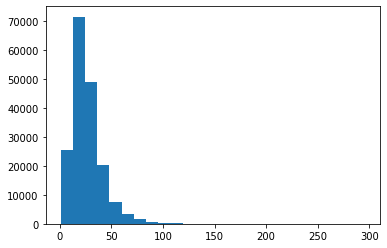

In [53]:
plt.hist(train_df.sentence_length, bins = 25)
plt.show()

In [54]:
#get 75% and 95 % int to use in tokenizer output length
txt_len_75 = int(train_df.sentence_length.describe()['75%'])
txt_len_95 = int(np.percentile(train_df.sentence_length, 95))
txt_len_75, txt_len_95

(33, 55)

NOTE: sentence length spread is quite extreme and there is an abundance of values with more than 33 words, 95% of all sentences fall into the lengths of 55 (or under) --> using 50 words as output length to account for most sentences lengths

In [55]:
out_len = 50
MAX_TOKENS = 68000 #number from Table 2 in paper cited above

In [56]:
#create tokenizer / vectorizerlayer
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS, standardize='lower_and_strip_punctuation',
    split='whitespace', ngrams=None, output_mode='int',
    output_sequence_length=out_len, pad_to_max_tokens=True, vocabulary=None
)
#fit tokenizer to train sentences
vectorizer.adapt(X_train)

In [57]:
#check tokenizer vocab
len(vectorizer.get_vocabulary()), vectorizer.get_vocabulary()[-10:]

(64841,
 ['aarm',
  'aaqol',
  'aaq',
  'aanhui',
  'aana',
  'aainduced',
  'aaigroup',
  'aachener',
  'aachen',
  'aaacp'])

In [58]:
"bioinformatics" in vectorizer.get_vocabulary()

False

In [59]:
#embed
embedder = tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), # set input shape --> = length of vocabulary
                             output_dim=516, # set size of embedding vector,
                             mask_zero=True,
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=out_len) # how long is each input 

In [60]:
random_text = random.choice(X_train)
print(random_text)
print(vectorizer([random_text]))
print(embedder(vectorizer([random_text])))

occluded vision in seniors seems to prolong this period up to @ min .
tf.Tensor(
[[8213 1922    5 8575 1529    6 5487   23  173  303    6  242    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], shape=(1, 50), dtype=int64)
tf.Tensor(
[[[-0.0087521   0.01704646  0.04905221 ...  0.02989708  0.03858671
   -0.02399713]
  [-0.00540137 -0.02095549 -0.00614965 ...  0.00257479 -0.03523976
    0.01282111]
  [ 0.02184042 -0.00874195 -0.01212107 ...  0.03159361  0.0317611
    0.03523907]
  ...
  [-0.04561064  0.02651793 -0.00658645 ...  0.03354182  0.01081447
   -0.00603552]
  [-0.04561064  0.02651793 -0.00658645 ...  0.03354182  0.01081447
   -0.00603552]
  [-0.04561064  0.02651793 -0.00658645 ...  0.03354182  0.01081447
   -0.00603552]]], shape=(1, 50, 516), dtype=float32)


In [61]:
#convert data into tf datasets, so that running efficiency is increased when loading data into model
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, encoded_train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, encoded_test_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, encoded_val_labels))

In [62]:
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [63]:
#create dataset batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [64]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [65]:
#build model - using functional keras
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
x = vectorizer(inputs)
x = embedder(x)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)  #use SOFTMAX for non-binary categorical!!
Conv1D_model = tf.keras.Model(inputs, outputs, name="Conv1D")

In [66]:
#summarize model
Conv1D_model.summary()

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 516)           33457956  
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 64)            165184    
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 33,623,465
Trainable params: 33,623,465
Non-trainable params: 0
________________________________________________

In [67]:
#compile
Conv1D_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [68]:
#fit
conv1D_history = Conv1D_model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=3,
    validation_data=val_dataset,
    validation_steps=int(0.1*len(val_dataset))
)

Epoch 1/3
5627/5627 [==============================] - 238s 37ms/step - loss: 0.5457 - accuracy: 0.7986 - val_loss: 0.5011 - val_accuracy: 0.8122
Epoch 2/3
5627/5627 [==============================] - 207s 37ms/step - loss: 0.3360 - accuracy: 0.8821 - val_loss: 0.5806 - val_accuracy: 0.8042
Epoch 3/3
5627/5627 [==============================] - 207s 37ms/step - loss: 0.1765 - accuracy: 0.9425 - val_loss: 0.7331 - val_accuracy: 0.7889


In [69]:
Conv1D_model.evaluate(val_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.7310 - accuracy: 0.7926


[0.731009304523468, 0.7926320433616638]

In [70]:
!mkdir -p saved_model
Conv1D_model.save('saved_model/Conv1D_model1')

INFO:tensorflow:Assets written to: saved_model/Conv1D_model1/assets


In [71]:
conv1d_preds_probs = Conv1D_model.predict(val_dataset)

In [72]:
conv1d_preds = tf.math.argmax(conv1d_preds_probs, axis=1)

In [73]:
lab_encoded_val_labels

array([0, 0, 3, ..., 4, 1, 1])

In [80]:
conv1D_metrics = calculate_results(lab_encoded_val_labels, conv1d_preds)
conv1D_metrics

{'accuracy': 79.26320667284523,
 'f1': 0.7898031817477734,
 'precision': 0.7910569268842946,
 'recall': 0.7926320667284523}

In [79]:
# conv1D_metrics = {'accuracy': 78.81967430160202,
#  'f1': 0.7859960928563114,
#  'precision': 0.7892146068302194,
#  'recall': 0.7881967430160202}

In [81]:
baseline_metrics

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

Helper functions

In [82]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  PARAMS:
    y_true(np.array) - true labels in the form of a 1D array
    y_pred(np.array) - predicted labels in the form of a 1D array
  RETURNS:
    model_results (dict) - a dictionary of accuracy, precision, recall, f1-score.
  """
  from sklearn.metrics import accuracy_score, precision_recall_fscore_support
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

### Transfer Learning Model: with Tensorflow model + Feature Extraction and pretrained token embeddings

In [85]:
#load pre-trained model as base for this model; feature extraction pnly, so --> not trainable
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], 
                                        dtype=tf.string, 
                                        trainable=False, 
                                        name="use") 

In [87]:
random_text

'occluded vision in seniors seems to prolong this period up to @ min .'

In [94]:
# check if loaded model works + length of output (=a 512-vector)
len(use_layer([random_text])[0])

512

In [98]:
#build model based on pretrained embedding (use)
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = use_layer(inputs)
x = tf.keras.layers.Dense(128, activation="relu")(pretrained_embedding)
output = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model_pretrained_embedding = tf.keras.Model(inputs, output)

In [100]:
#compile model
model_pretrained_embedding.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [102]:
model_pretrained_embedding.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
use (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 256,830,981
Trainable params: 33,157
Non-trainable params: 256,797,824
_________________________________________________________________


In [101]:
#fit model
model_pretrained_embedding.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=3,
    validation_data=val_dataset,
    validation_steps=int(0.1*len(val_dataset))
)

Epoch 1/3
5627/5627 [==============================] - 109s 19ms/step - loss: 0.7533 - accuracy: 0.7122 - val_loss: 0.6752 - val_accuracy: 0.7427
Epoch 2/3
5627/5627 [==============================] - 107s 19ms/step - loss: 0.6611 - accuracy: 0.7487 - val_loss: 0.6401 - val_accuracy: 0.7606
Epoch 3/3
5627/5627 [==============================] - 107s 19ms/step - loss: 0.6288 - accuracy: 0.7613 - val_loss: 0.6240 - val_accuracy: 0.7630


In [103]:
#evaluate model, predict and get performance metrics
model_pretrained_embedding.evaluate(val_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.6270 - accuracy: 0.7601


[0.6269599795341492, 0.7600952982902527]

In [113]:
model_pretrained_embedding_preds = model_pretrained_embedding.predict(val_dataset)

In [114]:
model_pretrained_embedding_preds = np.array(tf.math.argmax(model_pretrained_embedding_preds, axis=1))

In [115]:
model_pretrained_embedding_preds

array([0, 1, 0, ..., 4, 4, 1])

In [116]:
lab_encoded_val_labels

array([0, 0, 3, ..., 4, 1, 1])

In [118]:
model_pretrained_embedding_metrics = calculate_results(lab_encoded_val_labels, model_pretrained_embedding_preds)
model_pretrained_embedding_metrics

{'accuracy': 76.00953263603866,
 'f1': 0.7553966219715307,
 'precision': 0.7571118640167971,
 'recall': 0.7600953263603866}

In [119]:
conv1D_metrics

{'accuracy': 79.26320667284523,
 'f1': 0.7898031817477734,
 'precision': 0.7910569268842946,
 'recall': 0.7926320667284523}

### Conv1D with character embeddings

#####  create text vectorizer that works at character-level

In [123]:
#convert word-based sentences into string of individual characters
def sentence_to_char(sentence_list):
  """
  Takes list of sentences and separates all words in each sentece into individual characters
  """
  char_list = [" ".join(list(sentence)) for sentence in sentence_list]  #list(string) - converts string into list of individual characters in the string
  return char_list

In [127]:
X_train_chars = sentence_to_char(X_train)
X_test_chars = sentence_to_char(X_test)
X_val_chars = sentence_to_char(X_val)

In [129]:
#calculate average number of characters in training sentences --> see length in cell below; NOTE:output of this cell also counts introduced whitespace
np.mean([len(sent) for sent in X_train_chars])

297.7325149966674

In [138]:
char_nums = [len(sent) for sent in X_train]

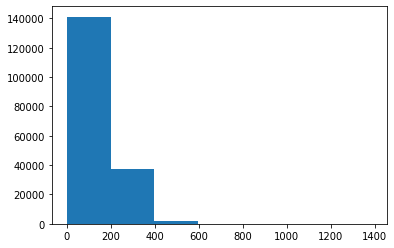

In [139]:
plt.hist(char_nums, bins=7)
plt.show()

In [165]:
#get 75% and 95 % int to use in character tokenizer output length
txt_len_75 = int(np.percentile(char_nums, 75))
txt_len_95 = out_len = int(np.percentile(char_nums, 95))
txt_len_75, txt_len_95

(189, 290)

In [144]:
#max. number of tokens in vectorizer needs to be the max. number of all aplhanumeric characters plus punctuation available
import string
all_chars = string.ascii_lowercase + string.digits + string.punctuation
all_chars

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [166]:
#max number of tokens to use in vectorizer is the number of all_chars PLUS 2 (1 for ' ' and 1 for OOV/['UNK'])
MAX_TOKENS =len(all_chars)
MAX_TOKENS

68

In [167]:
#instantiate
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS, #number of words in vectorizer vocab
    standardize='lower_and_strip_punctuation',
    split='whitespace', ngrams=None, output_mode='int',
    output_sequence_length=out_len, #number of words each vectorized inpit nis limited to (here: 290, as this captures 95% of all sentence lengths)
    pad_to_max_tokens=True, vocabulary=None,
    name="char_vectorizer"
)

In [168]:
#adapt tp X_train
char_vectorizer.adapt(X_train_chars)

In [169]:
#check vocab
char_vectorizer.get_vocabulary(), len(char_vectorizer.get_vocabulary())

(['',
  '[UNK]',
  'e',
  't',
  'i',
  'a',
  'n',
  'o',
  'r',
  's',
  'd',
  'c',
  'l',
  'h',
  'p',
  'm',
  'u',
  'f',
  'g',
  'y',
  'w',
  'v',
  'b',
  'k',
  'x',
  'z',
  'q',
  'j'],
 28)

##### create embedder that works at char-level and with char-vectorizer

In [170]:
#embed
char_embedder = tf.keras.layers.Embedding(input_dim=len(char_vectorizer.get_vocabulary()), # set input shape --> = length of vocabulary
                             output_dim=25, # set size of embedding vector --> 25 as per model in paper that I am trying to reproduce
                             mask_zero=True,
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=out_len, # how long is each input 
                             name="char_embed")

In [171]:
print(f"Indiv. character sentence: {random_text}")
print(f"Sentence vectorized (with a length of {len(char_vectorizer([random_text])[0])}): \n{char_vectorizer([random_text])}")
print(f"Embedding of vectorized sentence (with a length of {len(char_embedder(char_vectorizer([random_text]))[0][0])} each): \n{char_embedder(char_vectorizer([random_text]))}")

Indiv. character sentence: occluded vision in seniors seems to prolong this period up to @ min .
Sentence vectorized (with a length of 290): 
[[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0]]
Embedding of vectorized sentence (with a length of 25 each): 
[[[ 0.01040469 -0.02757432 -0.02865853 ... -0.02507263  0.04656357
    0.00173384]
  [ 0.01040469 -0.02757432 -0.02865853 ... -0.02507263  0.04656357
    0.00173384]
  [ 0.01040469 -0.02757432 -0.